In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from cdlib import algorithms, viz, evaluation
import copy
# import tensorflow as tf

In [2]:
# with open('../../GCN/evaluation_2019/pred_list.pkl', 'rb') as f:
with open('../../GCN/evaluation_2019/pred_list2019.pkl', 'rb') as f:
    pred_list= pickle.load(f) 

In [3]:
pred_list[0].shape

torch.Size([900, 2])

In [4]:
def pred_list_to_adj(pred, country_num=30):
    adj = np.zeros([country_num, country_num])
    for source in range(country_num):
        for target in range(country_num):
            if(source==target):
                continue
            if(pred[30*source + target][0] < pred[30*source + target][1]):
                adj[source,target] = +1
    return adj

In [5]:
travel_df = pd.read_csv('../csv/global_travel_df.csv')
countries = travel_df['node'].unique().T

In [6]:
with open('../pkl/new_country_order.pkl', 'rb') as f:
    new_order = pickle.load(f) 

In [7]:
label_dict = dict(zip(np.char.mod('%d', range(226)), countries[new_order]))
label_dict = dict(zip(range(30), countries[new_order]))

In [8]:
label_dict

{0: 'US',
 1: 'GB',
 2: 'FR',
 3: 'ES',
 4: 'IT',
 5: 'DE',
 6: 'MX',
 7: 'CA',
 8: 'JP',
 9: 'NL',
 10: 'BR',
 11: 'TH',
 12: 'ID',
 13: 'MY',
 14: 'SG',
 15: 'BE',
 16: 'AE',
 17: 'AU',
 18: 'CH',
 19: 'PH',
 20: 'IE',
 21: 'PT',
 22: 'AR',
 23: 'TR',
 24: 'RU',
 25: 'KW',
 26: 'CN',
 27: 'IN',
 28: 'HK',
 29: 'AT'}

In [9]:
with open('../pkl/global_weekly_sorted_tensor2.pkl', 'rb') as f:
    travel_tensors_raw= pickle.load(f) 

In [10]:
country_cutline = 30 # 69, 70 give None homogeneity
travel_tensors = travel_tensors_raw[:,0:country_cutline,0:country_cutline]

In [11]:
adj_list = []
interval = 50 # 26 * 4 weeks = 2 year,
for i in range(interval):
    ajm = np.sum(travel_tensors[4*i:4 + 4*i][:,0:country_cutline,0:country_cutline], axis=0)
    adj_list.append(ajm)

In [12]:
pred_density = []
pred_adj = []
for i in range(10):
    adj = pred_list_to_adj(pred_list[i])
    den = np.sum(adj>0)/(30*29)
    pred_density.append(den)
    pred_adj.append(adj)
    print(den)
pred_adj = np.array(pred_adj)

0.7689655172413793
0.9988505747126437
0.871264367816092
0.7896551724137931
0.4459770114942529
0.2885057471264368
0.20689655172413793
0.4724137931034483
0.6068965517241379
0.42758620689655175


In [13]:
real_density = [] 
for i in range(10):
    den = np.sum(adj_list[-10+i]>0)/(30*29)
    real_density.append(den)
    print(den)

0.3931034482758621
0.31494252873563217
0.31494252873563217
0.20689655172413793
0.14367816091954022
0.1413793103448276
0.2103448275862069
0.21149425287356322
0.18160919540229886
0.13333333333333333


In [14]:
week_slices = pd.date_range('2016-01-04', periods=200+1, freq='W')
# week_slices[0::4]
week_slices

DatetimeIndex(['2016-01-10', '2016-01-17', '2016-01-24', '2016-01-31',
               '2016-02-07', '2016-02-14', '2016-02-21', '2016-02-28',
               '2016-03-06', '2016-03-13',
               ...
               '2019-09-08', '2019-09-15', '2019-09-22', '2019-09-29',
               '2019-10-06', '2019-10-13', '2019-10-20', '2019-10-27',
               '2019-11-03', '2019-11-10'],
              dtype='datetime64[ns]', length=201, freq='W-SUN')

In [15]:
np.linalg.norm(pred_density)

2.0176552609439495

In [16]:
# from sklearn.preprocessing import normalize
def scale(pred_density):
    return (pred_density - np.min(pred_density))/(np.max(pred_density)-np.min(pred_density))

In [17]:
week_slices[0::4][-10:]

DatetimeIndex(['2019-03-03', '2019-03-31', '2019-04-28', '2019-05-26',
               '2019-06-23', '2019-07-21', '2019-08-18', '2019-09-15',
               '2019-10-13', '2019-11-10'],
              dtype='datetime64[ns]', freq='4W-SUN')

In [18]:
week_slices

DatetimeIndex(['2016-01-10', '2016-01-17', '2016-01-24', '2016-01-31',
               '2016-02-07', '2016-02-14', '2016-02-21', '2016-02-28',
               '2016-03-06', '2016-03-13',
               ...
               '2019-09-08', '2019-09-15', '2019-09-22', '2019-09-29',
               '2019-10-06', '2019-10-13', '2019-10-20', '2019-10-27',
               '2019-11-03', '2019-11-10'],
              dtype='datetime64[ns]', length=201, freq='W-SUN')

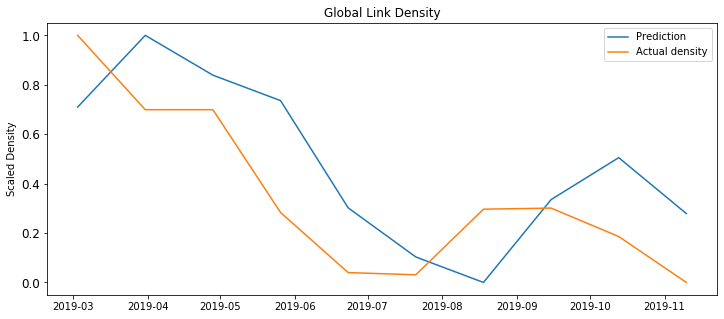

In [27]:
plt.figure(figsize=(12,5))
xaxis = week_slices[0::4][-10:]
plt.plot(xaxis, scale(pred_density), label = "Prediction")
plt.plot(xaxis, scale(real_density), label = "Actual density")
plt.title("Global Link Density")
plt.ylabel("Scaled Density")
plt.yticks(fontsize=12)
plt.legend()

In [20]:
country_num = 28

In [21]:
outd_pred = np.sum(pred_adj[:,country_num,:],axis=1)
ind_pred = np.sum(pred_adj[:,:,country_num],axis=1)
total_degree_pred = outd_pred + ind_pred

In [22]:
adj_array = np.array(adj_list)
outd_real = np.sum(adj_array[:,country_num,:]>0,axis=1)
ind_real = np.sum(adj_array[:,:,country_num]>0,axis=1)
total_degree_real = outd_real + ind_real

In [23]:
outw_real = np.sum(adj_array[:,country_num,:],axis=1)
inw_real = np.sum(adj_array[:,:,country_num],axis=1)
total_weight_real = outw_real + inw_real

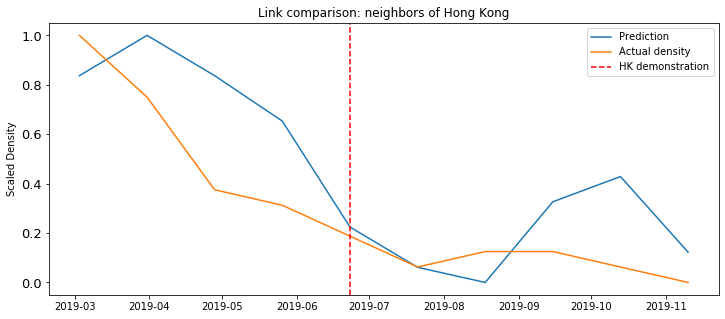

In [26]:
plt.figure(figsize=(12,5))
plt.yticks(fontsize=13)
xaxis = week_slices[0::4][-10:]
plt.plot(xaxis, scale(total_degree_pred[0:]), label = "Prediction")
# plt.plot(xaxis, total_weight_real[-10:], label = "Actual weights")
plt.plot(xaxis, scale(total_degree_real[-10:]), label = "Actual density")
plt.axvline(x=xaxis[-6], linestyle='--', color='red', label="HK demonstration")
# plt.axvline(x=xaxis[-2], linestyle='dotted', color='purple', label="Maximum gap")
plt.ylabel("Scaled Density")
plt.title("Link comparison: neighbors of Hong Kong")
plt.legend()

In [25]:
with open('../../GCN/edge_pred/pred_list.pkl', 'rb') as f:
    pred_edge= pickle.load(f) 

In [28]:
with open('../../GCN/edge_pred/idx_list.pkl', 'rb') as f:
    edge_idx= pickle.load(f) 

In [29]:
time = -1

In [30]:
def update_pred(time=-1):
    local_pred = copy.deepcopy(pred_adj[time]) 
    edge_adj = np.zeros([country_cutline,country_cutline])
    for i in range(1,edge_idx[time].shape[1]):
            r = edge_idx[time][0][i]
            c = edge_idx[time][1][i]
            if(pred_edge[time][i][0] < pred_edge[time][i][1]):
                local_pred[r][c] = local_pred[r][c]*1
    return local_pred

In [68]:
# update_pred(time=-1)
predG_list = []
predWAdj_list = []
predcoms_list = []
length = len(pred_adj)
for i in range(length):
    adj = update_pred(time=(-1*length+i))
    predWAdj_list.append(adj)
    temp_G = nx.from_numpy_matrix(adj, create_using=nx.DiGraph)
    temp_G = nx.relabel_nodes(temp_G, label_dict) 
    predG_list.append(temp_G)
    predcoms_list.append(algorithms.leiden(temp_G, weights='weight'))

predWAdj_list = np.array(predWAdj_list)

/Users/gimpuleumoe/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/gimpuleumoe/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


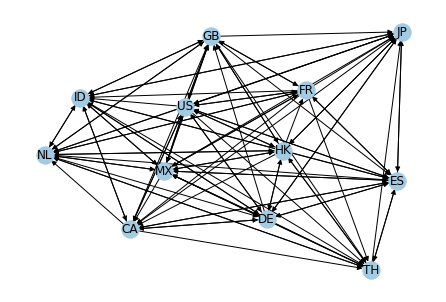

In [58]:
G = nx.ego_graph(predG_list[-2], 'HK')
pos = nx.spring_layout(G)
# colors = range(1)
nx.draw(G, pos, node_color='#A0CBE2', 
        radius = 1,
#         edge_color=colors,
        width=1, edge_cmap=plt.cm.Blues, with_labels=True)
# nx.draw_networkx_labels(G,pos=nx.spring_layout(G))

In [59]:
# nx.write_edgelist(G, "pred_HK.csv")

In [60]:
print(xaxis[-3], xaxis[-2])

2019-09-15 00:00:00 2019-10-13 00:00:00


In [69]:
realG_list = []
realcoms_list = []
for i in range(len(pred_adj)):
    temp_G = nx.from_numpy_matrix(adj_list[-10+i], create_using=nx.DiGraph)
    temp_G = nx.relabel_nodes(temp_G, label_dict) 
    realG_list.append(temp_G)
    realcoms_list.append(algorithms.leiden(temp_G, weights='weight'))

/Users/gimpuleumoe/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/gimpuleumoe/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


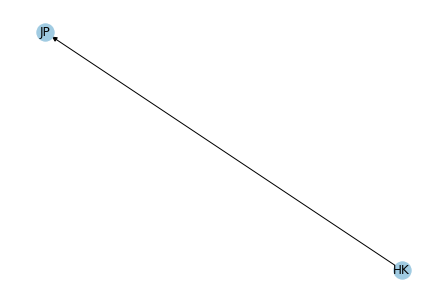

In [62]:
# realG_list[4]
G = nx.ego_graph(realG_list[-2], 'HK')
pos = nx.spring_layout(G)
# colors = range(1)
nx.draw(G, pos, node_color='#A0CBE2', 
#         edge_color=colors,
        width=1, edge_cmap=plt.cm.Blues, with_labels=True)
# nx.draw_networkx_labels(G,pos=nx.spring_layout(G))

['US', 'GB', 'FR', 'ES', 'IT', 'DE', 'MX', 'CA', 'JP', 'NL', 'BR', 'TH', 'ID', 'MY', 'SG', 'BE', 'AE', 'AU', 'CH', 'PH', 'IE', 'PT', 'AR', 'TR', 'RU', 'KW', 'CN', 'IN', 'HK', 'AT']
['US', 'GB', 'FR', 'ES', 'IT', 'DE', 'MX', 'CA', 'JP', 'NL', 'BR', 'TH', 'ID', 'MY', 'SG', 'BE', 'AE', 'AU', 'CH', 'PH', 'IE', 'PT', 'AR', 'TR', 'RU', 'KW', 'CN', 'IN', 'HK', 'AT']
['US', 'GB', 'FR', 'ES', 'IT', 'DE', 'MX', 'CA', 'JP', 'NL', 'BR', 'TH', 'ID', 'MY', 'SG', 'BE', 'AE', 'AU', 'CH', 'PH', 'IE', 'PT', 'AR', 'TR', 'RU', 'KW', 'CN', 'IN', 'HK', 'AT']
['US', 'GB', 'FR', 'ES', 'IT', 'DE', 'MX', 'CA', 'JP', 'NL', 'BR', 'TH', 'ID', 'MY', 'SG', 'BE', 'AE', 'AU', 'CH', 'PH', 'IE', 'PT', 'AR', 'TR', 'RU', 'KW', 'IN', 'HK', 'AT']
['US', 'GB', 'FR', 'ES', 'IT', 'DE', 'MX', 'CA', 'JP', 'NL', 'BR', 'TH', 'ID', 'MY', 'SG', 'BE', 'AE', 'AU', 'CH', 'PH', 'IE', 'PT', 'AR', 'RU', 'KW', 'CN', 'IN', 'HK', 'AT']
['US', 'GB', 'FR', 'ES', 'IT', 'DE', 'MX', 'CA', 'JP', 'NL', 'BR', 'TH', 'ID', 'MY', 'SG', 'BE', 'AE', 'AU'

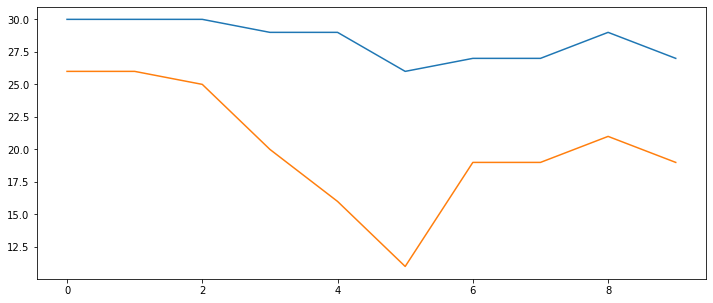

In [72]:
a = []
for i in (predG_list):
    tempG = nx.ego_graph(i, 'US')
    print(tempG.nodes)
    a.append(len(tempG.nodes))

b= []
for i in (realG_list):
    tempG = nx.ego_graph(i, 'US')
    print(tempG.nodes)
    b.append(len(tempG.nodes))

plt.figure(figsize=(12,5))
plt.plot((a))
plt.plot((b))

In [64]:
# nx.write_edgelist(G, "real_HK.csv")

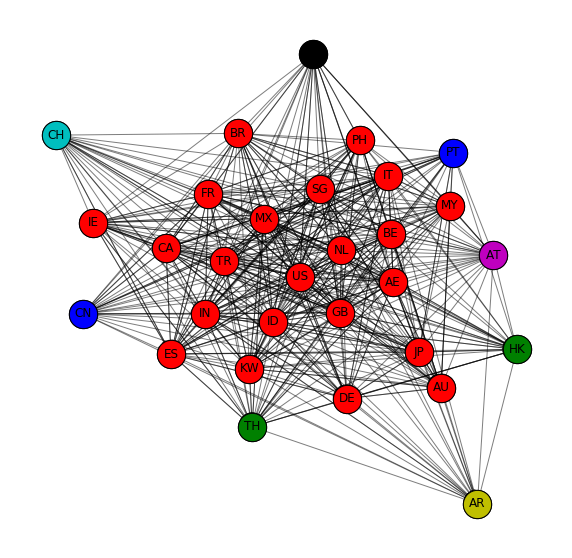

In [65]:
time = -2
G = predG_list[time]
coms = predcoms_list[time]
pos = nx.spring_layout(G, k=1)
# ego_graph = nx.ego_graph(G, 'HK', radius=2)
viz.plot_network_clusters(G, coms, pos, figsize=(10, 10), plot_labels=True, node_size=800)

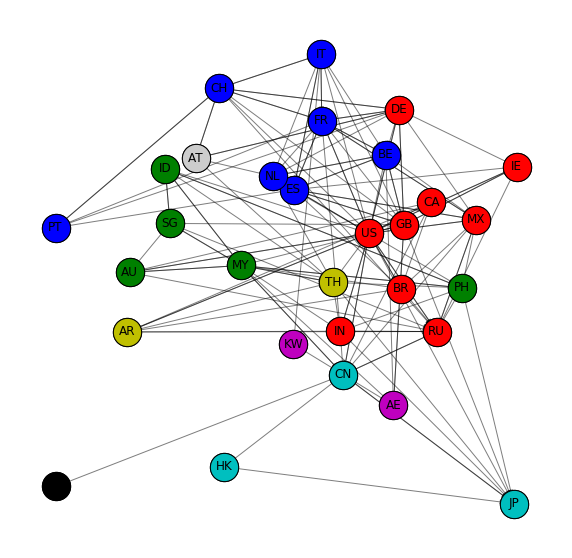

In [67]:
G = realG_list[time]
coms = realcoms_list[time]
pos = nx.spring_layout(G, k=1)
# ego_graph = nx.ego_graph(G, 'HK', radius=2)
viz.plot_network_clusters(G, coms, pos, figsize=(10, 10), plot_labels=True, node_size=800)